### This kernel was created to the <a target="_blank" href="https://www.kaggle.com/c/LANL-Earthquake-Prediction">LANL Earthquake Prediction</a> competition.
### Here we plot the raw data and then aplly a Convolution Neural Network on the images.

In [34]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout, Activation, BatchNormalization
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import mean_absolute_error

### Here is an example of image that will be the input of the CNN:

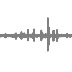

In [22]:
Image("../input/lanlimages/images/images/training_set/val_0/3828-2.913799.jpg") # The time to failure of this segment is at the file name (2.913799)

In [23]:
img_width = 72
img_height = 72
TRAIN_DIR = '../input/lanlimages/images/images/training_set/val_'
TEST_DIR = '../input/lanlimages/images/images/test_set/'
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [24]:
folds = 5
train_images = [[],[],[],[],[]]
for fold in range(folds):
    train_images[fold] = []
    for i in os.listdir(TRAIN_DIR + str(fold)):
        train_images[fold].append(TRAIN_DIR + str(fold) + '/' + i)

In [25]:
val_X_cnn = []
val_y_cnn = []
train_X_cnn = []
train_y_cnn = []
seg_id_val_cnn = [[],[],[],[],[]]
seg_id_train_cnn = [[],[],[],[],[]]
seg_id_test_cnn = []

val_X_cnn.append(train_images[0])
val_y_cnn.append(np.zeros(len(val_X_cnn[0])))
train_X_cnn.append(train_images[1]+train_images[2]+train_images[3]+train_images[4])
train_y_cnn.append(np.zeros(len(train_X_cnn[0])))

val_X_cnn.append(train_images[1])
val_y_cnn.append(np.zeros(len(val_X_cnn[1])))
train_X_cnn.append(train_images[0]+train_images[2]+train_images[3]+train_images[4])
train_y_cnn.append(np.zeros(len(train_X_cnn[1])))

val_X_cnn.append(train_images[2])
val_y_cnn.append(np.zeros(len(val_X_cnn[2])))
train_X_cnn.append(train_images[0]+train_images[1]+train_images[3]+train_images[4])
train_y_cnn.append(np.zeros(len(train_X_cnn[2])))

val_X_cnn.append(train_images[3])
val_y_cnn.append(np.zeros(len(val_X_cnn[3])))
train_X_cnn.append(train_images[0]+train_images[1]+train_images[2]+train_images[4])
train_y_cnn.append(np.zeros(len(train_X_cnn[3])))

val_X_cnn.append(train_images[4])
val_y_cnn.append(np.zeros(len(val_X_cnn[4])))
train_X_cnn.append(train_images[0]+train_images[1]+train_images[2]+train_images[3])
train_y_cnn.append(np.zeros(len(train_X_cnn[4])))

In [26]:
def prepare_data(list_of_images, dataset):
    """
    Returns two arrays:
        x is an array of images
        y is an array of labels
    """
    x = [] # images as arrays
    y = [] # labels
    seg_id = []
    
    for image in list_of_images:
        x.append(cv2.imread(image,cv2.IMREAD_GRAYSCALE))
        if dataset != 'test':
            y.append(float(image.split('-')[-1][:-4])) # [:-4] is to remove the file extension
        
        if dataset == 'validation':
            seg_id.append(image.split('/')[-1].split('-')[0])
        
        if dataset == 'test':
            seg_id.append(image.split('/')[-1].split('.')[0])
            
    return x, y, seg_id

In [27]:
for fold in range(folds):
    train_X_cnn[fold], train_y_cnn[fold], seg_id_train_cnn[fold] = prepare_data(train_X_cnn[fold], 'training') #seg_id_train will be []
    val_X_cnn[fold], val_y_cnn[fold], seg_id_val_cnn[fold] = prepare_data(val_X_cnn[fold], 'validation')
test_X_cnn, test_y_cnn, seg_id_test_cnn = prepare_data(test_images, 'test')  #test_y will be []

In [28]:
train_X_cnn = np.array(train_X_cnn)
val_X_cnn = np.array(val_X_cnn)
test_X_cnn = np.array(test_X_cnn)

In [29]:
train_X_cnn = train_X_cnn.reshape(train_X_cnn.shape[0], train_X_cnn.shape[1], train_X_cnn.shape[2], train_X_cnn.shape[3], 1)
val_X_cnn = val_X_cnn.reshape(val_X_cnn.shape[0], val_X_cnn.shape[1], val_X_cnn.shape[2], val_X_cnn.shape[3], 1)
test_X_cnn = test_X_cnn.reshape(test_X_cnn.shape[0], test_X_cnn.shape[1], test_X_cnn.shape[2], 1)

In [30]:
train_X_cnn[0].shape, val_X_cnn[0].shape, test_X_cnn.shape

((3352, 72, 72, 1), (838, 72, 72, 1), (2624, 72, 72, 1))

In [31]:
nb_train_samples = train_X_cnn[0].shape[0]
nb_validation_samples = val_X_cnn[0].shape[0]
batch_size = 64

In [32]:
oof_cnn = np.zeros(len(train_X_cnn[0])+len(val_X_cnn[0]))
all_y_cnn = np.zeros(len(oof_cnn))
predictions_cnn = np.zeros(len(test_X_cnn))

for fold in range (folds):
    print('fold: ', fold)
    print('----------')
    # Initialising the CNN
    model = Sequential()
    # Step 1 - Convolution
    model.add(Conv2D(32, (5, 5), input_shape = (72, 72, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # Step 2 - Pooling
    model.add(MaxPooling2D(pool_size = (2, 2)))
    # Adding a second convolutional layer
    model.add(Conv2D(64, (3, 3), use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    # Step 3 - Flattening
    model.add(Flatten())
    # Step 4 - Full connection
    model.add(Dense(units = 2056, kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(rate=0.3))
    model.add(Activation('relu'))
    # Step 5 - Output Layer
    model.add(Dense(units = 1, activation = 'linear'))
    # Compiling the CNN
    model.compile(optimizer = 'Adam', loss = 'mean_absolute_error')
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow(train_X_cnn[fold], train_y_cnn[fold], batch_size=batch_size, shuffle=False)
    validation_generator = val_datagen.flow(val_X_cnn[fold], val_y_cnn[fold], batch_size=batch_size, shuffle=False)
    test_generator = test_datagen.flow(test_X_cnn, batch_size=batch_size, shuffle=False)
    # EarlyStopping
    es = EarlyStopping(monitor='val_loss', patience=8, mode='auto', restore_best_weights=True)
    # Fitting
    model.fit_generator(train_generator, steps_per_epoch=nb_train_samples // batch_size, callbacks=[es],
                        epochs=40, validation_data=validation_generator, validation_steps=nb_validation_samples // batch_size)
    # Predicting
    index_start = len(val_X_cnn[0])*fold
    index_end = index_start + len(val_X_cnn[0])
    oof_cnn[index_start:index_end] = model.predict_generator(generator=validation_generator, steps=len(validation_generator), verbose=1).reshape(1,-1)
    all_y_cnn[index_start:index_end] = val_y_cnn[fold]
    predictions_cnn += model.predict_generator(generator=test_generator, steps=len(test_generator), verbose=1)[:,0] / folds

oof_cnn = np.where(oof_cnn < 0, 0, oof_cnn) # Removing negative predictions
predictions_cnn = np.where(predictions_cnn < 0, 0, predictions_cnn) # Removing negative predictions
print('CV MAE: {}'.format(mean_absolute_error(all_y_cnn, oof_cnn)))

fold:  0
----------
Epoch 1/1
41/41 [==============================] - 11s 279ms/step
fold:  1
----------
Epoch 1/1
41/41 [==============================] - 11s 257ms/step
fold:  2
----------
Epoch 1/1
41/41 [==============================] - 11s 260ms/step
fold:  3
----------
Epoch 1/1
41/41 [==============================] - 11s 256ms/step
fold:  4
----------
Epoch 1/1
41/41 [==============================] - 11s 270ms/step
CV MAE: 4.296993799755136


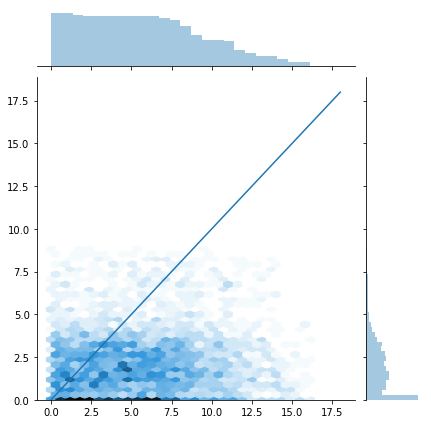

In [38]:
g = sns.jointplot(x=all_y_cnn,y=oof_cnn,kind='hex')
lims = [18,0]
g.ax_joint.plot(lims, lims)

## Submission

In [39]:
submission = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
submission.time_to_failure = predictions_cnn
submission.to_csv('submission.csv',index=True)

## Conclusion
#### This technique give us a reasonable result, considering that we are not using any numerical features. Besides, we can create a more complex neural network combining a MLP (numerical features) with a CNN (images), this can be done with the Keras functional API.